<a href="https://colab.research.google.com/github/akimotolab/CMAES_Tutorial/blob/main/a1_minmax_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolution Strategyによるミニマックス最適化

ここではESを用いたミニマックス最適化について紹介する．
特に，
1. 局所探索を志向した方法である Adversarial-CMA-ES [1] （pythonコード： https://gist.github.com/youheiakimoto/ab51e88c73baf68effd95b750100aad0#comments）

2. 大域探索＆並列化を志向した方法である WRA-CMA-ES [2] (pythonコード： https://github.com/akimotolab/worstcase-ranking-approximation)

を紹介する．

[1] Youhei Akimoto, Yoshiki Miyauchi, and Atsuo Maki. 2022.
Saddle Point Optimization with Approximate Minimization Oracle and Its Application to Robust Berthing Control.
ACM Trans. Evol. Learn. Optim. 2, 1, Article 2 (March 2022), 32 pages.
DOI:https://doi.org/10.1145/3510425

[2] Atsuhiro Miyagi, Yoshiki Miyauchi, Atsuo Maki, Kazuto Fukuchi, Jun Sakuma, and Youhei Akimoto. 2023. Covariance Matrix Adaptation Evolutionary Strategy with Worst-Case Ranking Approximation for Min-Max Optimization and Its Application to Berthing Control Tasks. ACM Trans. Evol. Learn. Optim. 3, 2, Article 8 (June 2023), 32 pages. https://doi.org/10.1145/3603716

## 背景

ESが活用される場面では，多くの場合，目的関数$f$は与えられた入力$x$に対する数値シミュレーションを介して計算される．
当然，シミュレーションによって計算される目的関数値が，現実世界に実装した場合の解$x$の良さを表していることを期待するが，現実的にはそうならない場合が多く見られる．
例えば，タイヤの形状を最適化するような場面を考える．どのような指標を良さに表すのかについては議論しないが，タイヤの形状の良し悪しを評価するためにシミュレーションを実施すると言っても，路面の状態や気象状況によってシミュレーションの結果が変わることは容易に想像される．
ここでいう，路面の状態や気象状況などの，シミュレーション実施時には知り得ない（運用時の天候はシミュレーション実施時にはわからない），もしくはそもそも一意に定まらない（天候も路面状態も運用する時々で変化する）ような要因を不確実性などと呼ぶ．
これを$y$で表すことにする．
この$y$は，シミュレーションの条件設定を表していると考えることもできる．
一般的な最適化の場合，最適化実施前に$y$を予め決めておき，
$$
x^* = \mathrm{argmax}_x f(x, y)
$$
となるような解$x^*$を求めようとしている，と考えられる．
しかし，最適化実施時に設定した$y_\mathrm{sim}$と運用時に直面する$y$が異なることで，目的関数値が著しく悪化する，すなわち$f(x^*, y_\mathrm{sim}) \ll f(x^*, y)$となる可能性がある．

### テスト問題での例
具体的なテスト問題２つでこの現象を確認する．

#### 凹凸二次関数
１つ目の問題は凹凸二次関数
$$
f(x, y) = a x^2 + b x y - c y^2
$$
である．
簡単のため，定義域は$\mathbb{R} \times \mathbb{R}$とする．
係数については，$a, c > 0$，$b \in \mathbb{R}$とする．
各$y$について，最適な$x$は
$$
x^*(y) = \frac{-by}{2a}
$$
であることから，最適な$x$が$y$に依存することがわかる．
とりわけ，$| b | / a$が大きいほど，$y$の変化に対して最適解が大きく変化することがわかる．
各$y$について，最適解をとった場合の目的関数値は
$$
f(x^*(y), y) = - \left( \frac{b^2}{4a} + c\right) y^2
$$
となる．
しかし，最適化時に用いた$y_\mathrm{sim}$と運用時の$y$が異なれば，
$$
f(x^*(y_\mathrm{sim}), y) = \frac{b^2}{4 a} \left( y_\mathrm{sim} - y\right)^2 - \left(\frac{b^2}{4 a} + c\right) y^2
$$
となる．
すなわち，第一項の分だけ，本来の最適な値よりも損をすることになる．
第一項はシミュレーションに用いた$y_\mathrm{sim}$と運用時の$y$が離れているほどに大きくなることも見て取れる．

#### 双線形関数
２つ目の問題は双線形関数
$$
f(x, y) = x y
$$
である．
定義域は$[-1, 1]\times [-1, 1]$とする．
各$y$について最適な解は
$$
x^*(y) = -\mathrm{sign}(y)
$$
となる．
$y=0$の場合には，任意の$x$が最適となるが，簡単のため$x^* = 0$と考えることにする．
この問題の場合，最適解が不連続に変化することになる．
各$y$について，最適解をとった場合の目的関数値は
$$
f(x^*(y), y) = - |y|
$$
となる．
他方，最適化時に用いた$y_\mathrm{sim}$と運用時の$y$が異なれば，
$$
f(x^*(y_\mathrm{sim}), y) = - \mathrm{sign}(y_\mathrm{sim}) y
$$
となる．
最適化時に用いた$y_\mathrm{sim}$と運用時の$y$の符号が一致している限り，最適化で得られた解が運用時にも最適な解となるが，符号が一致していない場合には性能劣化が起こることが見て取れる．

## ミニマックス最適化問題
不確実性を含む問題においては，様々なアプローチが考えられるが，ここでは「考えうる最悪なシナリオでの性能を最適化する解を求める問題」を考える．
運用時に起こり得る不確実性の集合$Y$を予め特定できると考える．
ある解$x$が与えられたもとで，この$x$にとって最悪性能を与える$y \in Y$を考える．
この最悪性能を表す指標を
$$
F_Y(x) = \max_{y \in Y} f(x, y)
$$
と書けば，この最悪性能$F_Y$を最小化するような解を見つけることがここでの目的であり，これはミニマックス最適化
$$
x^* = \mathrm{argmax}_x F_Y(x) = \mathrm{argmax}_x \max_{y \in Y} f(x, y)
$$
として定式化される．
ESが対象とするような最適化問題において，目的関数はブラックボックスであるため，最悪性能$F_Y(x)$を解析的に求めることはできない．そのため，$F_Y(x)$を求めるために，各$x$に対して最悪なシナリオを求める必要がある．実用上は$Y$を適切に定めることも困難さの一つといえるが，この資料ではその後の最適化のみに着目する．

## ナイーブなアプローチ：有限サンプルを用いた最悪ケースの近似

最も単純な方法としては，$Y$上の事前分布から予め$M$個の値$y_1, \dots, y_M$をサンプリングしておき，もしくは最悪シナリオの後を予め予測できる場合には用意しておき，最悪性能を
$$
\tilde{F}_Y(x) = \max_{m=1, \dots, M} f(x, y_m)
$$
で近似する方法が考えられる．
この場合，一度の$\tilde{F}_Y(x)$の計算に$M$回のシミュレーション（$f(x, y_m)$の計算）が必要になるが，並列評価可能であれば，一度のシミュレーション時間で$\tilde{F}_Y$を計算することが可能であり，また，通常の進化戦略を用いて最適化することができる．
この方法で実用に耐えうる解が得られる場合もあるが，一般に，サンプリングされたシナリオから離れたシナリオに対しては性能の低い解が得られる．

### テスト問題での実行例

凹凸二次関数を用いた場合の近似最悪性能と真の最悪性能の差を確認する．

In [1]:
import numpy as np

# 簡単のため， x と y の次元数は等しいとする．
N = 1
a = c = 1.0
b = 10.0

def f(x, y):
    return a * np.dot(x, x) + b * np.dot(x, y) - c * np.dot(y, y)

def f_worst(x):
    y = b * x / 2 / c
    return f(x, y)

# シナリオサンプル．ここでは標準正規分布からサンプリング
M = 10
y_array = np.random.randn(M, N)
def f_worst_approx(x):
    return max([f(x, y) for y in y_array])

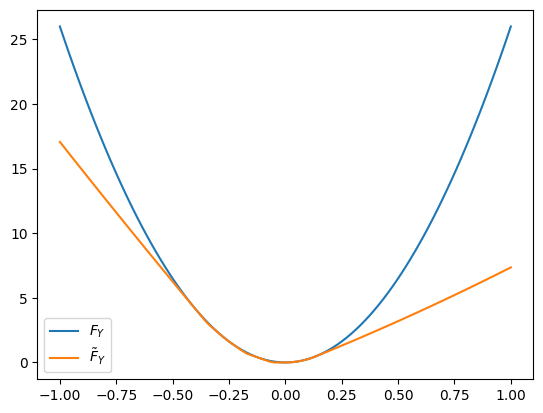

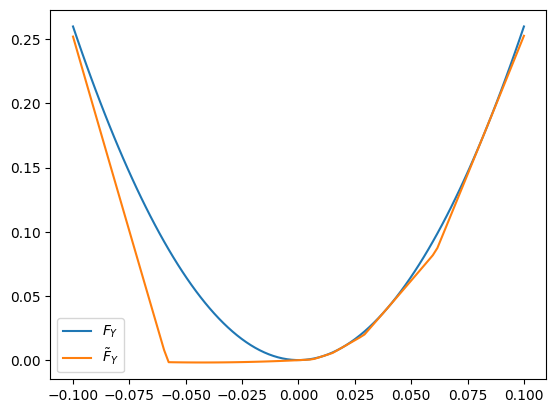

In [2]:
import matplotlib.pyplot as plt

x_array = np.linspace(-1, 1, 100)
f_worst_array = np.array([f_worst(x) for x in x_array])
f_worst_approx_array = np.array([f_worst_approx(x) for x in x_array])

plt.figure()
plt.plot(x_array, f_worst_array, label=r'$F_Y$')
plt.plot(x_array, f_worst_approx_array, label=r'$\tilde{F}_Y$')
plt.legend()

x_array = np.linspace(-0.1, 0.1, 100)
f_worst_array = np.array([f_worst(x) for x in x_array])
f_worst_approx_array = np.array([f_worst_approx(x) for x in x_array])

plt.figure()
plt.plot(x_array, f_worst_array, label=r'$F_Y$')
plt.plot(x_array, f_worst_approx_array, label=r'$\tilde{F}_Y$')
plt.legend()

近似最悪性能$\tilde{F}_Y(x)$は必ず真の最悪性能$F_Y(x)$以下の値となる．大域的にみると，$F_Y$の最適解近傍での関数値が$\tilde{F}_{Y}$によってよく近似されているように見える（乱数による）が，最適解近傍を拡大すると，$\tilde{F}_Y$の最適解は$F_Y$の最適解$x^* = 0$から離れていることがわかる．

### CMA-ESで最適化
DD-CMA-ESを用いて最適化してみる．

#### DD-CMA-ES　（実行後，非表示推奨）
以下のコードはgistからのコピー: https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518

In [3]:
import warnings
from collections import deque
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class DdCma:
    """dd-CMA: CMA-ES with diagonal decoding [1]
    Note
    ----
    If you are interested in constrained optimization and/or multi-fidelity optimization,
    check the following repository:
    https://github.com/akimotolab/multi-fidelity

    History
    -------
    2022/03/24: Mirroring box constraint handling and periodic variable handling [3] have been implemented.
    2020/06/10: Restart (IPOP mechanism) [2] has been implemented.
    2019/03/23: release
    Reference
    ---------
    [1] Y. Akimoto and N. Hansen.
    Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies
    Evolutionary Computation (2020) 28(3): 405--435.
    [2] A. Auger and N. Hansen.
    A Restart CMA Evolution Strategy With Increasing Population Size
    IEEE Congress on Evolutionary Computation (2005): 1769-1776.
    [3] Y. Yamaguchi and A. Akimoto.
    A Note on the CMA-ES for Functions with Periodic Variables
    Genetic and Evolutionary Computation Conference Companion (2018): 227-228.
    """

    def __init__(self, xmean0, sigma0,
                 lam=None,
                 flg_covariance_update=True,
                 flg_variance_update=True,
                 flg_active_update=True,
                 flg_force_correlation=None,
                 beta_eig=None,
                 beta_thresh=2.):
        """
        Parameters
        ----------
        xmean0 : 1d array-like
            initial mean vector
        sigma0 : 1d array-like
            initial diagonal decoding
        lam : int, optional (default = None)
            population size
        flg_covariance_update : bool, optional (default = True)
            update C if this is True
        flg_variance_update : bool, optional (default = True)
            update D if this is True
        flg_active_update : bool, optional (default = True)
            update C and D with active update
        flg_force_correlation : bool or None, optional (default = None)
            force C to be a correlation matrix if True
            None : flg_force_correlation = flg_variance_update
        beta_eig : float, optional (default = None)
            coefficient to control the frequency of matrix decomposition
        beta_thresh : float, optional (default = 2.)
            threshold parameter for beta control
        """
        self.N = len(xmean0)
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))

        # options
        self.flg_covariance_update = flg_covariance_update
        self.flg_variance_update = flg_variance_update
        self.flg_active_update = flg_active_update
        self.flg_force_correlation = flg_variance_update if flg_force_correlation is None else flg_force_correlation
        self.beta_eig = beta_eig if beta_eig else 10. * self.N
        self.beta_thresh = beta_thresh

        # parameters for recombination and step-size adaptation
        self.lam = lam if lam else 4 + int(3 * math.log(self.N))
        assert self.lam > 2
        w = math.log((self.lam + 1) / 2.0) - np.log(np.arange(1, self.lam+1))
        w[w > 0] /= np.sum(np.abs(w[w > 0]))
        w[w < 0] /= np.sum(np.abs(w[w < 0]))
        self.mueff_positive = 1. / np.sum(w[w > 0] ** 2)
        self.mueff_negative = 1. / np.sum(w[w < 0] ** 2)
        self.cm = 1.
        self.cs = (self.mueff_positive + 2.) / (self.N + self.mueff_positive + 5.)
        self.ds = 1. + self.cs + 2. * max(0., math.sqrt((self.mueff_positive - 1.) / (self.N + 1.)) - 1.)

        # parameters for covariance matrix adaptation
        expo = 0.75
        mu_prime = self.mueff_positive + 1. / self.mueff_positive - 2. + self.lam / (2. * self.lam + 10.)
        m = self.N * (self.N + 1) / 2
        self.cone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cmu = min(1. - self.cone, mu_prime * self.cone)
        self.cc = math.sqrt(self.mueff_positive * self.cone) / 2.
        self.w = np.array(w)
        self.w[w < 0] *= min(1. + self.cone / self.cmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))

        # parameters for diagonal decoding
        m = self.N
        self.cdone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cdmu = min(1. - self.cdone, mu_prime * self.cdone)
        self.cdc = math.sqrt(self.mueff_positive * self.cdone) / 2.
        self.wd = np.array(w)
        self.wd[w < 0] *= min(1. + self.cdone / self.cdmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))

        # dynamic parameters
        self.xmean = np.array(xmean0)
        self.D = np.array(sigma0)
        self.sigma = 1.
        self.C = np.eye(self.N)
        self.S = np.ones(self.N)
        self.B = np.eye(self.N)
        self.sqrtC = np.eye(self.N)
        self.invsqrtC = np.eye(self.N)
        self.Z = np.zeros((self.N, self.N))
        self.pc = np.zeros(self.N)
        self.pdc = np.zeros(self.N)
        self.ps = np.zeros(self.N)
        self.pc_factor = 0.
        self.pdc_factor = 0.
        self.ps_factor = 0.

        # others
        self.teig = max(1, int(1. / (self.beta_eig * (self.cone + self.cmu))))
        self.neval = 0
        self.t = 0
        self.beta = 1.

        # strage for checker and logger
        self.arf = np.zeros(self.lam)
        self.arx = np.zeros((self.lam, self.N))

    def transform(self, z):
        y = np.dot(z, self.sqrtC) if self.flg_covariance_update else z
        return y * (self.D * self.sigma)

    def transform_inverse(self, y):
        z = y / (self.D * self.sigma)
        return np.dot(z, self.invsqrtC) if self.flg_covariance_update else z

    def sample(self):
        arz = np.random.randn(self.lam, self.N)
        ary = np.dot(arz, self.sqrtC) if self.flg_covariance_update else arz
        arx = ary * (self.D * self.sigma) + self.xmean
        return arx, ary, arz

    def update(self, idx, arx, ary, arz):
        # shortcut
        w = self.w
        wc = self.w
        wd = self.wd
        sarz = arz[idx]
        sary = ary[idx]
        sarx = arx[idx]

        # recombination
        dz = np.dot(w[w > 0], sarz[w > 0])
        dy = np.dot(w[w > 0], sary[w > 0])
        self.xmean += self.cm * self.sigma * self.D * dy

        # step-size adaptation
        self.ps_factor = (1 - self.cs) ** 2 * self.ps_factor + self.cs * (2 - self.cs)
        self.ps = (1 - self.cs) * self.ps + math.sqrt(self.cs * (2 - self.cs) * self.mueff_positive) * dz
        normsquared = np.sum(self.ps * self.ps)
        hsig = normsquared / self.ps_factor / self.N < 2.0 + 4.0 / (self.N + 1)
        self.sigma *= math.exp((math.sqrt(normsquared) / self.chiN - math.sqrt(self.ps_factor)) * self.cs / self.ds)

        # C (intermediate) update
        if self.flg_covariance_update:
            # Rank-mu
            if self.cmu == 0:
                rank_mu = 0.
            elif self.flg_active_update:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
                rank_mu += np.dot(sarz[wc<0].T * (wc[wc<0] * self.N / np.linalg.norm(sarz[wc<0], axis=1) ** 2),
                                  sarz[wc<0]) - np.sum(wc[wc<0]) * np.eye(self.N)
            else:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
            # Rank-one
            if self.cone == 0:
                rank_one = 0.
            else:
                self.pc = (1 - self.cc) * self.pc + hsig * math.sqrt(self.cc * (2 - self.cc) * self.mueff_positive) * self.D * dy
                self.pc_factor = (1 - self.cc) ** 2 * self.pc_factor + hsig * self.cc * (2 - self.cc)
                zpc = np.dot(self.pc / self.D, self.invsqrtC)
                rank_one = np.outer(zpc, zpc) - self.pc_factor * np.eye(self.N)
            # Update
            self.Z += (self.cmu * rank_mu + self.cone * rank_one)

        # D update
        if self.flg_variance_update:
            # Cumulation
            self.pdc = (1 - self.cdc) * self.pdc + hsig * math.sqrt(self.cdc * (2 - self.cdc) * self.mueff_positive) * self.D * dy
            self.pdc_factor = (1 - self.cdc) ** 2 * self.pdc_factor + hsig * self.cdc * (2 - self.cdc)
            DD = self.cdone * (np.dot(self.pdc / self.D, self.invsqrtC) ** 2 - self.pdc_factor)
            if self.flg_active_update:
                # positive and negative update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD += self.cdmu * np.dot(wd[wd<0] * self.N / np.linalg.norm(sarz[wd<0], axis=1)**2, sarz[wd<0]**2)
                DD -= self.cdmu * np.sum(wd)
            else:
                # positive update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD -= self.cdmu * np.sum(wd[wd>0])
            if self.flg_covariance_update:
                self.beta = 1 / max(1, np.max(self.S) / np.min(self.S) - self.beta_thresh + 1.)
            else:
                self.beta = 1.
            self.D *= np.exp((self.beta / 2) * DD)

        # update C
        if self.flg_covariance_update and (self.t + 1) % self.teig == 0:
            D = np.linalg.eigvalsh(self.Z)
            fac = min(0.75 / abs(D.min()), 1.)
            self.C = np.dot(np.dot(self.sqrtC, np.eye(self.N) + fac * self.Z), self.sqrtC)

            # force C to be correlation matrix
            if self.flg_force_correlation:
                cd = np.sqrt(np.diag(self.C))
                self.D *= cd
                self.C = (self.C / cd).T / cd

            # decomposition
            DD, self.B = np.linalg.eigh(self.C)
            self.S = np.sqrt(DD)
            self.sqrtC = np.dot(self.B * self.S, self.B.T)
            self.invsqrtC = np.dot(self.B / self.S, self.B.T)
            self.Z[:, :] = 0.

    def onestep(self, func):
        """
        Parameter
        ---------
        func : callable
            parameter : 2d array-like with candidate solutions (x) as elements
            return    : 1d array-like with f(x) as elements
        """
        # sampling
        arx, ary, arz = self.sample()

        # evaluation
        arf = func(arx)
        self.neval += len(arf)

        # sort
        idx = np.argsort(arf)
        if not np.all(arf[idx[1:]] - arf[idx[:-1]] > 0.):
            warnings.warn("assumed no tie, but there exists", RuntimeWarning)

        # update
        self.update(idx, arx, ary, arz)

        # finalize
        self.t += 1
        self.arf = arf
        self.arx = arx

    def upper_bounding_coordinate_std(self, coordinate_length):
        """Upper-bounding coordinate-wise standard deviation

        When some design variables are periodic, the coordinate-wise standard deviation
        should be upper-bounded by r_i / 4, where r_i is the period of the ith variable.
        The correction of the overall covariance matrix, Sigma, is done as follows:
            Sigma = Correction * Sigma * Correction,
        where Correction is a diagonal matrix defined as
            Correction_i = min( r_i / (4 * Sigma_{i,i}^{1/2}), 1 ).

        In DD-CMA, the correction matrix is simply multiplied to D.

        For example, if a mirroring box constraint handling is used for a box constraint
        [l_i, u_i], the variables become periodic on [l_i - (u_i-l_i)/2, u_i + (u_i-l_i)/2].
        Therefore, the period is
            r_i = 2 * (u_i - l_i).

        Parameters
        ----------
        coordinate_length : ndarray (1D) or float
            coordinate-wise search length r_i.

        References
        ----------
        T. Yamaguchi and Y. Akimoto.
        A Note on the CMA-ES for Functions with Periodic Variables.
        GECCO '18 Companion, pages 227--228 (2018)
        """
        correction = np.fmin(coordinate_length / self.coordinate_std / 4.0, 1)
        self.D *= correction


    @property
    def coordinate_std(self):
        if self.flg_covariance_update:
            return self.sigma * self.D * np.sqrt(np.diag(self.C))
        else:
            return self.sigma * self.D

class Checker:
    """BBOB ermination Checker for dd-CMA"""
    def __init__(self, cma):
        assert isinstance(cma, DdCma)
        self._cma = cma
        self._init_std = self._cma.coordinate_std
        self._N = self._cma.N
        self._lam = self._cma.lam
        self._hist_fbest = deque(maxlen=10 + int(np.ceil(30 * self._N / self._lam)))
        self._hist_feq_flag = deque(maxlen=self._N)
        self._hist_fmin = deque()
        self._hist_fmed = deque()

    def __call__(self):
        return self.bbob_check()

    def check_maxiter(self):
        return self._cma.t > 100 + 50 * (self._N + 3) ** 2 / np.sqrt(self._lam)

    def check_tolhistfun(self):
        self._hist_fbest.append(np.min(self._cma.arf))
        return (self._cma.t >= 10 + int(np.ceil(30 * self._N / self._lam)) and
                np.max(self._hist_fbest) - np.min(self._hist_fbest) < 1e-12)

    def check_equalfunvals(self):
        k = int(math.ceil(0.1 + self._lam / 4))
        sarf = np.sort(self._cma.arf)
        self._hist_feq_flag.append(sarf[0] == sarf[k])
        return 3 * sum(self._hist_feq_flag) > self._N

    def check_tolx(self):
        return (np.all(self._cma.coordinate_std / self._init_std) < 1e-12)

    def check_tolupsigma(self):
        return np.any(self._cma.coordinate_std / self._init_std > 1e3)

    def check_stagnation(self):
        self._hist_fmin.append(np.min(self._cma.arf))
        self._hist_fmed.append(np.median(self._cma.arf))
        _len = int(np.ceil(self._cma.t / 5 + 120 + 30 * self._N / self._lam))
        if len(self._hist_fmin) > _len:
            self._hist_fmin.popleft()
            self._hist_fmed.popleft()
        fmin_med = np.median(np.asarray(self._hist_fmin)[-20:])
        fmed_med = np.median(np.asarray(self._hist_fmed)[:20])
        return self._cma.t >= _len and fmin_med >= fmed_med

    def check_conditioncov(self):
        return (np.max(self._cma.S) / np.min(self._cma.S) > 1e7
                or np.max(self._cma.D) / np.min(self._cma.D) > 1e7)

    def check_noeffectaxis(self):
        t = self._cma.t % self._N
        test = 0.1 * self._cma.sigma * self._cma.D * self._cma.S[t] * self._cma.B[:, t]
        return np.all(self._cma.xmean == self._cma.xmean + test)

    def check_noeffectcoor(self):
        return np.all(self._cma.xmean == self._cma.xmean + 0.2 * self._cma.coordinate_std)

    def check_flat(self):
        return np.max(self._cma.arf) == np.min(self._cma.arf)

    def bbob_check(self):
        if self.check_maxiter():
            return True, 'bbob_maxiter'
        if self.check_tolhistfun():
            return True, 'bbob_tolhistfun'
        if self.check_equalfunvals():
            return True, 'bbob_equalfunvals'
        if self.check_tolx():
            return True, 'bbob_tolx'
        if self.check_tolupsigma():
            return True, 'bbob_tolupsigma'
        if self.check_stagnation():
            return True, 'bbob_stagnation'
        if self.check_conditioncov():
            return True, 'bbob_conditioncov'
        if self.check_noeffectaxis():
            return True, 'bbob_noeffectaxis'
        if self.check_noeffectcoor():
            return True, 'bbob_noeffectcoor'
        if self.check_flat():
            return True, 'bbob_flat'
        return False, ''


class Logger:
    """Logger for dd-CMA"""
    def __init__(self, cma, prefix='log', variable_list=['xmean', 'D', 'S', 'sigma', 'beta']):
        """
        Parameters
        ----------
        cma : DdCma instance
        prefix : string
            prefix for the log file path
        variable_list : list of string
            list of names of attributes of `cma` to be monitored
        """
        self._cma = cma
        self.neval_offset = 0
        self.t_offset = 0
        self.prefix = prefix
        self.variable_list = variable_list
        self.logger = dict()
        self.fmin_logger = self.prefix + '_fmin.dat'
        with open(self.fmin_logger, 'w') as f:
            f.write('#' + type(self).__name__ + "\n")
        for key in self.variable_list:
            self.logger[key] = self.prefix + '_' + key + '.dat'
            with open(self.logger[key], 'w') as f:
                f.write('#' + type(self).__name__ + "\n")

    def __call__(self, condition=''):
        self.log(condition)

    def setcma(self, cma):
        self.neval_offset += self._cma.neval
        self.t_offset += self._cma.t
        self._cma = cma

    def log(self, condition=''):
        neval = self.neval_offset + self._cma.neval
        t = self.t_offset + self._cma.t
        with open(self.fmin_logger, 'a') as f:
            f.write("{} {} {}\n".format(t, neval, np.min(self._cma.arf)))
            if condition:
                f.write('# End with condition = ' + condition)
        for key, log in self.logger.items():
            key_split = key.split('.')
            key = key_split.pop(0)
            var = getattr(self._cma, key)
            for i in key_split:
                var = getattr(var, i)
            if isinstance(var, np.ndarray) and len(var.shape) > 1:
                var = var.flatten()
            varlist = np.hstack((t, neval, var))
            with open(log, 'a') as f:
                f.write(' '.join(map(repr, varlist)) + "\n")

    def my_formatter(self, x, pos):
        """Float Number Format for Axes"""
        float_str = "{0:2.1e}".format(x)
        if self.latexmode:
            if "e" in float_str:
                base, exponent = float_str.split("e")
                return r"{0}e{1}".format(base, int(exponent))
            else:
                return r"" + float_str + ""
        else:
            if "e" in float_str:
                base, exponent = float_str.split("e")
                return "{0}e{1}".format(base, int(exponent))
            else:
                return "" + float_str + ""

    def plot(self,
             xaxis=0,
             ncols=None,
             figsize=None,
             cmap_='Spectral',
             latexmode=False):

        """Plot the result
        Parameters
        ----------
        xaxis : int, optional (default = 0)
            0. vs iterations
            1. vs function evaluations
        ncols : int, optional (default = None)
            number of columns
        figsize : tuple, optional (default = None)
            figure size
        cmap_ : string, optional (default = 'spectral')
            cmap
        latexmode : bool, optional (default = False)
            LaTeX is enabled if this is True

        Returns
        -------
        fig : figure object.
            figure object
        axdict : dictionary of axes
            the keys are the names of variables given in `variable_list`
        """
        self.latexmode = latexmode

        mpl.rc('lines', linewidth=2, markersize=8)
        mpl.rc('font', size=12)
        mpl.rc('grid', color='0.75', linestyle=':')
        if self.latexmode:
            mpl.rc('text', usetex=True)  # for a paper submision
            mpl.rc('ps', useafm=True)  # Force to use
            mpl.rc('pdf', use14corefonts=True)  # only Type 1 fonts
        prefix = self.prefix
        variable_list = self.variable_list

        # Default settings
        nfigs = 1 + len(variable_list)
        if ncols is None:
            ncols = int(np.ceil(np.sqrt(nfigs)))
        nrows = int(np.ceil(nfigs / ncols))
        if figsize is None:
            figsize = (4 * ncols, 3 * nrows)
        axdict = dict()

        # Figure
        fig = plt.figure(figsize=figsize)
        # The first figure
        x = np.loadtxt(prefix + '_fmin.dat')
        x = x[~np.isnan(x[:, xaxis]), :]  # remove columns where xaxis is nan
        # Axis
        ax = plt.subplot(nrows, ncols, 1)
        ax.set_title('fmin')
        ax.grid(True)
        ax.grid(which='major', linewidth=0.50)
        ax.grid(which='minor', linewidth=0.25)
        plt.plot(x[:, xaxis], x[:, 2:])
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        axdict['fmin'] = ax

        # The other figures
        idx = 1
        for key in variable_list:
            idx += 1
            x = np.loadtxt(prefix + '_' + key + '.dat')
            x = x[~np.isnan(
                x[:, xaxis]), :]  # remove columns where xaxis is nan
            ax = plt.subplot(nrows, ncols, idx)
            if self.latexmode:
                ax.set_title(r'\detokenize{' + key + '}')
            else:
                ax.set_title(key)
            ax.grid(True)
            ax.grid(which='major', linewidth=0.50)
            ax.grid(which='minor', linewidth=0.25)
            cmap = plt.get_cmap(cmap_)
            cNorm = mpl.colors.Normalize(vmin=0, vmax=x.shape[1] - 2)
            scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
            for i in range(x.shape[1] - 2):
                plt.plot(
                    x[:, xaxis], x[:, 2 + i], color=scalarMap.to_rgba(i))
            ax.xaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            ax.yaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            axdict[key] = ax

        plt.tight_layout() # NOTE: not sure if it works fine
        return fig, axdict

def random_rotation(self, func, dim):
    R = np.random.normal(0, 1, (dim, dim))
    for i in range(dim):
        for j in range(i):
            R[:, i] = R[:, i] - np.dot(R[:, i], R[:, j]) * R[:, j]
        R[:, i] = R[:, i] / np.linalg.norm(R[:, i])
    def rotatedfunc(x):
        return func(np.dot(x, R.T))
    return rotatedfunc

def mirror(z, lbound, ubound, flg_periodic):
    """Mirroring Box-Constraint Handling and Periodic Constraint Handling
    Parameters
    ----------
    z : ndarray (1D or 2D)
        solutions to be corrected
    lbound, ubound : ndarray (1D)
        lower and upper bounds
        If some variables are not bounded, set np.inf or -np.inf
    flg_periodic : ndarray (1D, bool)
        flag for periodic variables

    Returns
    -------
    projected solution in [lbound, ubound]
    """
    zz = np.copy(z)
    flg_lower = np.isfinite(lbound) * np.logical_not(np.isfinite(ubound) + flg_periodic)
    flg_upper = np.isfinite(ubound) * np.logical_not(np.isfinite(lbound) + flg_periodic)
    flg_box = np.isfinite(lbound) * np.isfinite(ubound) * np.logical_not(flg_periodic)
    width = ubound - lbound
    if zz.ndim == 1:
        zz[flg_periodic] = lbound[flg_periodic] + np.mod(zz[flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[flg_lower] = lbound[flg_lower] + np.abs(zz[flg_lower] - lbound[flg_lower])
        zz[flg_upper] = ubound[flg_upper] - np.abs(zz[flg_upper] - ubound[flg_upper])
        zz[flg_box] = ubound[flg_box] - np.abs(np.mod(zz[flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])
    elif zz.ndim == 2:
        zz[:, flg_periodic] = lbound[flg_periodic] + np.mod(zz[:, flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[:, flg_lower] = lbound[flg_lower] + np.abs(zz[:, flg_lower] - lbound[flg_lower])
        zz[:, flg_upper] = ubound[flg_upper] - np.abs(zz[:, flg_upper] - ubound[flg_upper])
        zz[:, flg_box] = ubound[flg_box] - np.abs(np.mod(zz[:, flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])
    return zz



#### 実行スクリプト
10次元の凹凸二次関数に対して，上で紹介したナイーブなアプローチを適用する．シナリオのサンプル数は10とする．
定義域は$[-5, 5]^N \times [-5, 5]^N$とする．

In [18]:
# 簡単のため， x と y の次元数は等しいとする．
N = 10
a = c = 1.0
b = 10.0

def f(x, y):
    return a * np.dot(x, x) + b * np.dot(x, y) - c * np.dot(y, y)

def f_worst(x):
    y = b * x / 2 / c
    return f(x, y)

# シナリオサンプル．ここでは標準正規分布からサンプリング
np.random.seed(100)
M = 10
y_array = np.random.randn(M, N)
def f_worst_approx(x):
    return max([f(x, y) for y in y_array])

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    if np.ndim(xx) == 1:
        return np.array([f_worst_approx(xx)])
    else:
        return np.array([f_worst_approx(xxx) for xxx in xx])

# Stopping Condition
F_TARGET = -np.inf   # target function value

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2.)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)

issatisfied = False
fbestsofar = np.inf
while not issatisfied:
    ddcma.onestep(func=fobj)
    ddcma.upper_bounding_coordinate_std(period_length)
    fbest = np.min(ddcma.arf)
    fbestsofar = min(fbest, fbestsofar)
    if fbest <= F_TARGET:
        issatisfied, condition = True, 'ftarget'
    else:
        issatisfied, condition = checker()
    if ddcma.t % 10 == 0:
        print(ddcma.t, ddcma.neval, fbest, fbestsofar)
        logger()
logger(condition)
print("Terminated with condition: " + str(condition))

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

TypeError: ignored

解を生成している正規分布の平均ベクトル（xmean）について，近似最悪性能と真の最悪性能の変化をプロットしてみる．

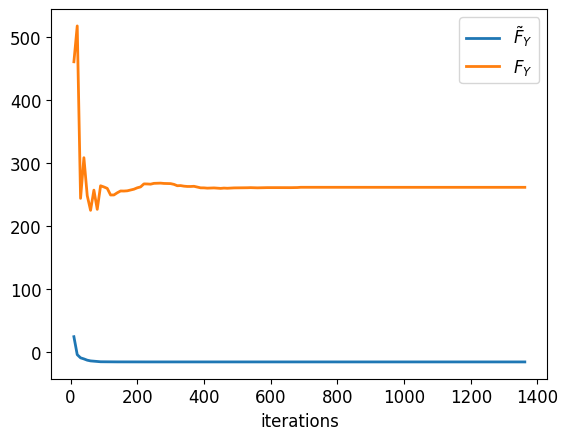

In [13]:
xmean_hist = np.loadtxt('log_xmean.dat')
fxmean_worst_approx_hist = np.array([f_worst_approx(x) for x in xmean_hist[:, 2:]])
fxmean_worst_hist = np.array([f_worst(x) for x in xmean_hist[:, 2:]])
plt.plot(xmean_hist[:, 0], fxmean_worst_approx_hist, label=r'$\tilde{F}_Y$')
plt.plot(xmean_hist[:, 0], fxmean_worst_hist, label=r'$F_Y$')
plt.xlabel('iterations')
plt.legend()


最終イテレーションでの平均ベクトルの値は以下の通り．

In [16]:
xmean_hist[-1, 2:]

array([ 1.59300861,  0.38105597, -0.3218619 , -2.16607407,  0.13427774,
       -0.35178987,  0.8705992 ,  0.30844918,  1.05122691,  0.69490419])

上の結果からわかるように，得られた解は真の最悪性能$F_Y$の最適解である$x^* = 0$から乖離しており，得られた解の最悪性能は真のそれ（$F_Y(x^*) = 0$）と比較して大きな値となっている．今回の問題の場合，主な原因は

1. サンプルしたシナリオ数がD=１０次元の不確実性空間においてM=10点のみとなっており，真の最悪性能を十分に良く近似することができないため

と考えられる．
これとは独立に，もう一つの困難さとして，

2. 近似最悪性能関数$\tilde{F}_Y$の局所解は多くの場合，複数のシナリオによって構成される部分の接点となっており，局所的に滑らかでない等高線を持つ関数となっている

という点も挙げておく．ただし，この問題の場合，１点目が大きな問題であるため，２点目がメインの困難さではないことに注意されたい．

## Adversarial-CMA-ES

Adversarial-CMA-ES は$x$についての最小化と$y$についての最大化を交互に実施することで，目的関数$f(x, y)$のミニマックス鞍点を求めることを目的として設計されている．
ここで，ミニマックス鞍点$(x^*, y^*)$とは，その近傍において
$$
f(x, y^*) > f(x^*, y^*) > f(x^*, y)
$$
が近傍上の任意の$(x, y)$について成り立つような点を表す．
すなわち，$x^*$のもとで$y^*$は局所的に目的関数$f(x^*, y)$を最大にする点であり，同時に，$y^*$のもとで$x^*$は局所的に目的関数$f(x, y^*)$を最小化する点である．
大域的なミニマックス鞍点がある場合，すなわち，任意の$(x, y)$に対して上の不等式が成立するような$(x^*, y^*)$が存在する場合には，そのような$x^*$が最悪性能$F_Y$の最適解である．
目的関数が狭義凹凸関数である場合には，最適解がミニマックス鞍点となることが知られており，ミニマックス鞍点を求めることが最適解を求めることに繋がる．
しかし，一般には，最悪性能$F_Y$の下での最適解がミニマックス鞍点となるとは限らないことに注意されたい．

### テスト問題での実行例

In [19]:
# https://gist.github.com/youheiakimoto/ab51e88c73baf68effd95b750100aad0
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
"""Adversarial-CMA-ES: derivative-free min-max optimization solver using (1+1)-CMA-ES [1]
It is an extention of Adversarial Evolution Strategy [2]
(https://gist.github.com/youheiakimoto/15212dbf46dc546af20af38b0b48ff17)
Reference
---------
[1] Youhei Akimoto, Yoshiki Miyauchi, and Atsuo Maki. 2022.
Saddle Point Optimization with Approximate Minimization Oracle and Its Application to Robust Berthing Control.
ACM Trans. Evol. Learn. Optim. 2, 1, Article 2 (March 2022), 32 pages.
DOI:https://doi.org/10.1145/3510425
[2] Youhei Akimoto. 2021.
Saddle point optimization with approximate minimization oracle.
In Proceedings of the Genetic and Evolutionary Computation Conference (GECCO '21).
Association for Computing Machinery, New York, NY, USA, 493–501.
DOI:https://doi.org/10.1145/3449639.3459266
"""


class Cmaes:
    """(1+1)-Active-CMA-ES [Arnold 2010] with Simplified 1/5th Success Rule"""

    def __init__(self, dim, tau, tau_offset, tolsigma=0.0, tolh=-np.inf, verbose=False):
        self.verbose = verbose
        self.tolsigma = tolsigma
        self.tolh = tolh

        self.dim = dim
        self.tau = tau
        self.tau_offset = tau_offset

        self.rescale_itr = 0

        self.aup = np.exp(2.0 / (2.0 + self.dim))
        self.adown = self.aup ** (-0.25)
        self.pthresh = 0.44
        self.cp = 1.0 / 12.0
        self.cc = 2.0 / (self.dim + 2)
        self.ccovp = 2.0 / (self.dim**2 + 6)
        self.ccovm = 0.4 / (self.dim**1.6 + 1)

        self.x = np.zeros(self.dim)
        self.s = 1.0
        self.psucc = 0.5
        self.fhist = []
        self.p = np.zeros(self.dim)
        self.chol = np.eye(self.dim)
        self.cholinv = np.eye(self.dim)

    def minimize(self, h, hx, x, sigma, chol, maxeval):
        """Locate approximate solutions to min_{x} h(x)
        Parameters
        ----------
        h : callable
            objective
        hx : float
            h(x) value
        x : ndarray (1d)
            initial solution
        sigma : float
            step-size
        chol : ndarray (2d)
            cholesky factor
        maxeval : int
            maximal number of f-calls
        Returns
        -------
        hz (float) : h(zt)
        zt (ndarray, 1d) : approximate solution
        theta (tuple) : parameters for z
        neval (int) : number of h-calls
        """
        nsucc = 0
        neval = 0
        self.x = np.copy(x)
        self.s = sigma
        self.psucc = 0.5
        self.fhist = [hx]
        self.p = np.zeros(self.dim)
        self.chol = np.copy(chol)
        self.cholinv = np.linalg.inv(self.chol)
        self.rescale()
        self.rescale_itr = 0
        while nsucc < self.dim * self.tau + self.tau_offset:
            z_, y_, x_ = self.generate()
            hx = h(x_)
            self.update(z_, y_, x_, hx)
            succ = hx <= self.fhist[0]
            nsucc += int(succ)
            neval += 1
            if self.rescale_itr > self.dim:
                self.rescale()
                self.rescale_itr = 0
            else:
                self.rescale_itr += 1
            if self.verbose:
                print(neval, hx, self.s)
            if self.s <= self.tolsigma or hx <= self.tolh or neval >= maxeval:
                break
        return self.fhist[0], self.x, max(self.s, self.tolsigma), self.chol, neval

    def generate(self):
        z = np.random.randn(self.dim)
        y = np.dot(self.chol, z)
        x = self.x + self.s * y
        return z, y, x

    def rescale(self):
        frob = np.sum(self.chol ** 2)
        scale = np.sqrt(frob / self.dim)
        self.s *= scale
        self.chol /= scale
        self.cholinv *= scale
        self.p /= scale

    def update(self, z, y, x, fx):
        if fx <= self.fhist[0]:
            self.fhist = [fx] + self.fhist[:min(4, len(self.fhist))]
            self.x = x
            self.s *= self.aup
            self.psucc = (1.0 - self.cp) * self.psucc + self.cp
            if self.psucc > self.pthresh:
                self.p = (1.0 - self.cc) * self.p
                d = self.ccovp * (1.0 - self.cc * (2.0 - self.cc))
            else:
                self.p = (1.0 - self.cc) * self.p + np.sqrt(self.cc * (2.0 - self.cc)) * y
                d = self.ccovp
            w = np.dot(self.cholinv, self.p)
            wnorm2 = np.dot(w, w)
            if wnorm2 > 1e-6:
                a = np.sqrt(1.0 - d)
                b = np.sqrt(1.0 - d) * (np.sqrt(1.0 + self.ccovp * wnorm2 / (1.0 - d)) - 1.0) / wnorm2
                self.chol = a * self.chol + b * np.outer(self.p, w)
                self.cholinv = self.cholinv / a - (b / (a**2 + a * b * wnorm2)) * np.outer(w, np.dot(w, self.cholinv))
        else:
            self.s *= self.adown
            self.psucc = (1.0 - self.cp) * self.psucc
            if len(self.fhist) > 4 and fx > self.fhist[4] and self.psucc <= self.pthresh:
                znorm2 = np.dot(z, z)
                ccov = self.ccovm if 1.0 >= self.ccovm * (2.0 * znorm2 - 1.0) else 1.0 / (2.0 * znorm2 - 1.0)
                a = np.sqrt(1.0 + ccov)
                b = np.sqrt(1.0 + ccov) * (np.sqrt(1.0 - ccov * znorm2 / (1.0 + ccov)) - 1) / znorm2
                self.chol = a * self.chol + b * np.outer(y, z)
                self.cholinv = self.cholinv / a - (b / (a**2 + a * b * znorm2)) * np.outer(z, np.dot(z, self.cholinv))


class AdversarialCmaes:

    def __init__(self, f, x_dim, y_dim, x_tau=5, y_tau=5, x_tau_offset=5, y_tau_offset=5, tolgap=0, aeta=1, beta=5, ceta=1.1, xsampler=None, ysampler=None, xsigma_min=0, ysigma_min=0, xlbound=None, xubound=None, ylbound=None, yubound=None, logpath=None, logchol=True):
        """Adversarial-CMA-ES

        Parameters
        ----------
        f : callable
            objective function
        x_dim, y_dim : int
            dimension of x and y
        x_tau, y_tau, x_tau_offset, y_tau_offset : int, optional
            number of iterations of the internal (1+1)-CMA-ES is
            x_tau * x_dim + x_tau_offset (for x) and
            y_tau * y_dim + y_tau_offset (for y).
        tolgap : float >= 0, optional
            termination condition.
            stop if the estimated suboptimality error is smaller than `tolgap`
        aeta, beta, ceta : float, optional
            hyper-parameters of the learning rate adaptation
            aeta, beta : the number of oracle calls to estimate the convergence rate is aeta / eta + beta
            ceta : learning rate is increased or decreased by the factor ceta
        xsampler, ysampler : callable, optional
            x and y samplers
        tolxsigma, tolysigma : float >= 0, optional
            minimal step-size
        xlbound, xubound : numpy.ndarray (1d)
            lower and upper bound of the search interval for x
        ylbound, yubound : numpy.ndarray (1d)
            lower and upper bound of the search interval for y
        logpath : str, optional
            log file name
        logchol : bool, optional
            write out the cholesky factor of the CMA-ES into the log file if this is true
        """
        self._f = f
        self.xsampler = xsampler
        self.ysampler = ysampler
        self.ysigma_min = ysigma_min
        self.x_cma = Cmaes(x_dim, x_tau, x_tau_offset, tolsigma=xsigma_min)
        self.y_cma = Cmaes(y_dim, y_tau, y_tau_offset, tolsigma=ysigma_min)
        self.tolgap = tolgap
        self.aeta = aeta
        self.beta = beta
        self.ceta = ceta
        self.xlbound = xlbound
        self.xubound = xubound
        self.ylbound = ylbound
        self.yubound = yubound
        self.logpath = logpath
        self.logchol = logchol
        self.neval = 0
        self.yhist = []

    def f(self, x, y):
        fxy = self._f(x, y)
        self.neval += 1
        return fxy

    def fyhist(self, x, y, twooutput=False):
        fxy = self.f(x, y)
        if len(self.yhist) > 0:
            fxyhist = np.max([self.f(x, yy) for yy in self.yhist])
            if twooutput:
                return max(fxyhist, fxy), fxy
            else:
                return max(fxyhist, fxy)
        else:
            if twooutput:
                return fxy, fxy
            else:
                return fxy

    def optimize_with(self, eta, x0, y0, xsigma0, ysigma0, xchol0, ychol0, nstep, maxeval, minitr):
        """Adversarial-CMA-ES with Fixed Learning Rate
        Parameters
        ----------
        eta : float
            learning rate
        x0, y0 : ndarray (1d)
            initial x and x
        xsigma0, ysigma0 : float
            initial step-size
        xchol0, ychol0 : ndarray (2d)
            initial cholesky factor
        nstep : int
            maximum iterations
        maxeval : int
            maximum number of f-calls
        minitr : int
            minimum iterations
        Returns
        -------
        x (ndarray, 1D) : solution
        y (ndarray, 1D) : solution
        gap (ndarray, 1D) : history of gap: f(x', yt) - f(xt, y')
        """

        x = np.copy(x0)
        y = np.copy(y0)
        xp = np.copy(x)
        yp = np.copy(y)
        x_sigma = xsigma0
        y_sigma = ysigma0
        x_chol = np.copy(xchol0)
        y_chol = np.copy(ychol0)
        dim_theta_x = 1 + len(x) ** 2 if self.logchol else 1
        dim_theta_y = 1 + len(y) ** 2 if self.logchol else 1
        res = np.zeros(1+1+1+1+len(x)+len(y)+dim_theta_x+dim_theta_y)
        gap_array = np.zeros(nstep)

        for i in range(nstep):
            # Determine whether or not to start from x or xp (y or yp)
            fxyhist, fxy = self.fyhist(x, y, twooutput=True)
            fxpy = self.fyhist(xp, y)
            fxyp = self.f(x, yp)
            if fxpy > fxyhist:
                xp[:] = x[:]
                fxpy = fxyhist
                x_sigma = xsigma0
                x_chol = np.copy(xchol0)
            if fxyp < fxy:
                yp[:] = y[:]
                fxyp = fxy
                y_sigma = ysigma0
                y_chol = np.copy(ychol0)

            # Adversarial steps
            fx, xp, x_sigma, x_chol, nx = self.x_cma.minimize(lambda z:  self.fyhist(z, y), fxpy, xp, x_sigma, x_chol, maxeval - self.neval)
            fy, yp, y_sigma, y_chol, ny = self.y_cma.minimize(lambda z:  -self.f(x, z), -fxyp, yp, y_sigma, y_chol, maxeval - self.neval)
            fy = -fy

            # Mirror solutions if the domain is bounded
            if self.xlbound is not None:
                xp = mirror(xp, self.xlbound, self.xubound)
            if self.ylbound is not None:
                yp = mirror(yp, self.ylbound, self.yubound)

            # Try random samples
            if self.xsampler is not None:
                xtrial = self.xsampler()
                fxytrial = self.fyhist(xtrial, y)
                nx += 1
                if fxytrial < fx:
                    xp = xtrial
                    fx = fxytrial
            if self.ysampler is not None:
                ytrial = self.ysampler()
                fxytrial = self.f(x, ytrial)
                ny += 1
                if fxytrial > fy:
                    if fy >= fxyhist:
                        self.register(yp)
                    yp = ytrial
                    fy = fxytrial

            # Estimated Suboptimality Error
            gap = max(fxyhist, fy) - fx

            # Update
            x += eta * (xp - x)
            y += eta * (yp - y)

            # Output
            idx = 0
            res[idx] = self.neval; idx += 1
            res[idx] = fxyhist; idx += 1
            res[idx] = gap; idx += 1
            res[idx] = eta; idx += 1
            res[idx:idx+len(x)] = x; idx += len(x)
            res[idx:idx+len(y)] = y; idx += len(y)
            res[idx] = x_sigma; idx += 1
            if self.logchol:
                res[idx:idx+dim_theta_x-1] = x_chol.flatten(); idx += dim_theta_x - 1
            res[idx] = y_sigma; idx += 1
            if self.logchol:
                res[idx:idx+dim_theta_x-1] = y_chol.flatten(); idx += dim_theta_y - 1
            with open(self.logpath, 'ba') as flog:
                np.savetxt(flog, res, newline=' ')
                flog.write(b"\n")

            # Termination condition
            gap_array[i] = gap
            if self.neval >= maxeval:
                break
            if gap_array[i] < self.tolgap:
                break
            if i >= minitr - 1:
                gap = gap_array[i+1-minitr:i+1]
                if minitr > 1 and np.all(gap[1:minitr] - gap[0:minitr-1] > 0):
                    break
        return x, y, gap_array[:i+1]


    def optimize(self, etamin, x0, y0, xsigma0, ysigma0, xchol0, ychol0, maxeval):
        """Adversarial Evolution Strategy with Learning Rate Adaptation
        Parameters
        ----------
        etamin : float
            minimal learning rate
        x0, y0 : ndarray (1d)
            initial x and x
        xsigma0, ysigma0 : float
            initial step-size
        xchol0, ychol0 : ndarray (2d)
            initial cholesky factor
        maxeval : int
            maximum number of f-calls
        Returns
        -------
        x (ndarray, 1D) : solution
        y (ndarray, 1D) : solution
        """
        x = np.copy(x0)
        y = np.copy(y0)
        x_sigma = xsigma0
        y_sigma = ysigma0
        x_chol = np.copy(xchol0)
        y_chol = np.copy(ychol0)
        eta = 1.0
        slp = 0.0
        while self.neval < maxeval:
            u = np.random.rand()
            if u < 1/3:
                eta1 = eta * self.ceta
            elif 1/3 <= u < 2/3:
                eta1 = eta
            else:
                eta1 = eta / self.ceta
            eta1 = np.clip(eta1, etamin, 1)
            nstep = self.beta + int(self.aeta/eta1)
            x1, y1, gap = self.optimize_with(eta1, x, y, x_sigma, y_sigma, x_chol, y_chol, nstep, maxeval, self.beta)
            if gap[-1] < self.tolgap or self.neval >= maxeval:
                break
            xarr = np.arange(len(gap))
            slp1, _, _, _, std1 = stats.linregress(xarr, np.log(np.fmax(gap, self.tolgap)))
            if slp1 - 2*std1 < 0:
                x = x1
                y = y1
                x_sigma = self.x_cma.s
                y_sigma = self.y_cma.s
                x_chol = self.x_cma.chol
                y_chol = self.y_cma.chol
            if slp >= 0 and slp1 >= 0:
                eta = np.clip(eta / self.ceta**3, etamin, 1)
                slp = 0.0
            elif slp1 <= slp:
                eta = eta1
                slp = slp1
            elif eta == eta1:
                slp = slp1
        return x1, y1

    def register(self, yp):
        if len(self.yhist) > 0:
            dist = np.asarray([np.linalg.norm(yh - yp) for yh in self.yhist])
            if np.min(dist) > self.ysigma_min * np.sqrt(len(yp)):
                self.yhist += [np.copy(yp)]
        else:
            self.yhist += [np.copy(yp)]


def mirror(z, lbound, ubound):
    width = ubound - lbound
    return ubound - np.abs(np.mod(z - lbound, 2 * width) - width)


def generate_cmaes_parameter(lbound, ubound):
    dim = len(lbound)
    x = lbound + (ubound - lbound) * np.random.rand(dim)
    sigma = 1.0
    chol = np.diag( (ubound - lbound) / 4. )
    return x, sigma, chol


def minmax(f, xlbound, xubound, ylbound, yubound, maxeval, bounded, etamin=1e-4, tolgap=1e-6, tolxsigma=1e-8, tolysigma=1e-8, logpath="advcma.csv", logchol=True, initx=None, initxsigma=None, inity=None, initysigma=None):
    """Optimize min-max problem f with Adversarial-CMA-ES with restart

    Parameters
    ----------
    f : callable
        min-max objective function f(x, y)
    xlbound, xubound : numpy.ndarray (1d)
        lower and upper bound of the initialization interval for x
    ylbound, yubound : numpy.ndarray (1d)
        lower and upper bound of the initialization interval for y
    maxeval : int
        maximum number of f-calls
    bounded : bool
        the domain is bounded (== initialization interval) if it is True
    etamin : float >= 0, optional
        minimal accepted learning rate
    tolgap : float >= 0, optional
        restart is performed if the suboptimality error reach this tolerance value
    tolxsigma, tolysigma : float >= 0, optional
        minimal step-size
    logpath : str, optional
        log file name
    logchol : bool, optional
        write out the cholesky factor of the CMA-ES into the log file if this is true
    initx, inity : numpy.ndarray (1d), optional
        initial guess
    initxsigma, initysigma : float > 0, optional
        initial step size, valid only when initx and inity are given
    Returns
    -------
    float : f(x, y) value
    numpy.ndarray (1d) : x best
    numpy.ndarray (1d) : y worst
    numpy.ndarray (2d) : f(x_i, y_j)
    list of numpy.ndarray (1d) : list of candidate x
    list of numpy.ndarray (1d) : list of candidate y
    """

    def xsampler():
        return xlbound + (xubound - xlbound) * np.random.rand(len(xlbound))
    def ysampler():
        return ylbound + (yubound - ylbound) * np.random.rand(len(ylbound))
    xhist = []
    if bounded:
        xl, xu, yl, yu = xlbound, xubound, ylbound, yubound
        def ff(x, y):
            xmirror = mirror(x, xlbound, xubound)
            ymirror = mirror(y, ylbound, yubound)
            return f(xmirror, ymirror)
    else:
        xl, xu, yl, yu = None, None, None, None
        ff = f
    advcma = AdversarialCmaes(ff, len(xlbound), len(ylbound), tolgap=tolgap, xsampler=xsampler, ysampler=ysampler, xlbound=xl, xubound=xu, ylbound=yl, yubound=yu, xsigma_min=tolxsigma, ysigma_min=tolysigma, logpath=logpath, logchol=logchol)
    while advcma.neval < maxeval:
        x0, xsigma0, xchol0 = generate_cmaes_parameter(xlbound, xubound)
        if len(xhist) == 0:
            if initx is not None:
                x0 = np.array(initx, copy=True)
                if initxsigma is not None:
                    xsigma0 = initxsigma
        y0, ysigma0, ychol0 = generate_cmaes_parameter(ylbound, yubound)
        if len(xhist) == 0:
            if inity is not None:
                y0 = np.array(inity, copy=True)
                if initysigma is not None:
                    ysigma0 = initysigma
        x, y = advcma.optimize(etamin, x0, y0, xsigma0, ysigma0, xchol0, ychol0, maxeval)
        xhist += [x]
        advcma.register(y)
    yhist = advcma.yhist
    f_arr = np.zeros((len(xhist), len(yhist)))
    for i, x in enumerate(xhist):
        for j, y in enumerate(yhist):
            f_arr[i, j] = f(x, y)
    xidx = np.argmin(np.max(f_arr, axis=1))
    yidx = np.argmax(f_arr[xidx])
    return f_arr[xidx, yidx], xhist[xidx], yhist[yidx], f_arr, xhist, yhist


def minimize(f, lbound, ubound, bounded, maxeval, totalmaxeval, tolsigma=1e-8, tolf=-np.inf):
    """Locate approximate solutions to min_{x} f(x)
    Parameters
    ----------
    f : callable
        objective
    lbound, ubound : numpy.ndarray (1d)
        lower and upper bound of the initialization interval for x
    bounded : bool
        the domain is bounded (== initialization interval) if it is True
    maxeval : int
        maximal number of f-calls for each (1+1)-CMA-ES run
    totalmaxeval : int
        maximal number of f-calls for restart
    tolxigma : float >= 0, optional
        minimal step-size
    tolf : float, optional
        minimal objective value
    Returns
    -------
    float : best f(x) value
    numpy.ndarray (1d) : best x
    numpy.ndarray (1d) : list of f(x)
    numpy.ndarray (2d) : list of x
    """

    if bounded:
        def h(z):
            zmirror = mirror(z, lbound, ubound)
            return f(zmirror)
    else:
        def h(z):
            return f(z)
    f_arr = []
    z_arr = []
    nfev = 0
    while nfev < totalmaxeval:
        z, sigma, chol = generate_cmaes_parameter(lbound, ubound)
        cma = Cmaes(len(z), tau=0, tau_offset=maxeval, tolsigma=tolsigma, tolh=tolf)
        hz, z, _, _, neval = cma.minimize(h, h(z), z, sigma, chol, min(maxeval, totalmaxeval - nfev - 1))
        nfev += neval + 1
        f_arr += [hz]
        z_arr += [mirror(z, lbound, ubound) if bounded else z]
    zidx = np.argmin(f_arr)
    return f_arr[zidx], z_arr[zidx], f_arr, z_arr


def worstsearch(f, x, ylbound, yubound, bounded, maxeval, tolsigma=1e-8, n_restart=100, inity=None, initysigma=None):
    """Worst case search by the (1+1)-CMA-ES

    Parameters
    ----------
    f : callable
        min-max objective function
    x : numpy.ndarray (1d)
        x to be evaluated
    ylbound, yubound : numpy.ndarray (1d)
        lower and upper bound of the initialization interval for y
    maxeval : int
        maximum number of f-calls for each restart
    tolsigma : float >= 0, optional
        minimal step-size
    n_restart : int >= 1, optional
        number of restart
    inity : numpy.ndarray (1d), optional
        initial solution
    initysigma : float > 0, optional
        initial step-size, valid only when inity is given
    Returns
    -------
    float : worst f(x, y) value
    numpy.ndarray (1d) : worst y
    numpy.ndarray (1d) : f(x, y_j)
    numpy.ndarray (2d) : list of candidate y
    """
    if bounded:
        def h(y):
            ymirror = mirror(y, ylbound, yubound)
            return -f(x, ymirror)
    else:
        def h(y):
            return -f(x, y)
    f_arr = np.zeros(n_restart)
    y_arr = np.zeros((n_restart, len(ylbound)))
    for i in range(n_restart):
        y, sigma, chol = generate_cmaes_parameter(ylbound, yubound)
        if i == 0:
            if inity is not None:
                y = np.array(inity)
                if initysigma is not None:
                    sigma = initysigma
        cma = Cmaes(len(y), tau=0, tau_offset=maxeval, tolsigma=tolsigma)
        hy, y, _, _, _ = cma.minimize(h, h(y), y, sigma, chol, maxeval)
        f_arr[i] = -hy
        y_arr[i] = mirror(y, ylbound, yubound) if bounded else y
    yidx = np.argmax(f_arr)
    return f_arr[yidx], y_arr[yidx], f_arr, y_arr



#### 実行スクリプト
以下では，前節においてナイーブなアプローチを評価した際と同じ目的関数に対し，Adversarial-CMA-ESを適用している．
関数 minmax がAdversarial-CMA-ESを実行する関数であり，最大評価回数に達するまでに自動的にリスタートがかかるようになっている．
ミニマックス最適化が終了した後，最悪性能をより正確に評価するために，関数 worstsearch により，得られた解$x^*$のもとでの目的関数$f(x^*, y)$の最大化を行っている．
今回のテスト関数の場合には真の最悪性能を計算できるため不要であるが，通常は真の最悪性能が評価できないためこのような評価を行う必要がある．

Optimization has started.
Optimization has finished.
best x: [ 5.37337112e-05 -5.84030215e-05 -1.27900586e-05 -3.65376065e-05
 -7.69818137e-05  6.75632374e-05  2.44250604e-05 -1.06984617e-04
  8.36227914e-05 -3.75695046e-05]
worst y: [-9.15851035e-05  5.02525653e-05  2.72482986e-05  9.11436203e-05
  2.54611610e-05 -1.12192295e-04 -9.07385274e-05  1.18534937e-04
 -1.06733320e-04  5.65214866e-05]
f(x,y): -2.1942027980827364e-07
[[-5.94022379e-08 -2.01743515e-06 -4.07327026e-06 -3.32706903e-06
  -6.04396926e-07 -1.60845795e-01]
 [-3.50344239e-07 -3.92645205e-07 -1.74930967e-06  1.84901419e-07
   1.38230157e-06 -1.60145784e-01]
 [-3.50344222e-07 -3.92023627e-07 -1.74967585e-06  1.84713638e-07
   1.38258633e-06 -1.60145759e-01]
 [-3.50344265e-07 -3.92626515e-07 -1.74978884e-06  1.84357597e-07
   1.38219999e-06 -1.60145772e-01]
 [-2.32331352e-07 -4.68897515e-07 -2.39457617e-06 -2.85375297e-07
   8.75573509e-07 -1.60440859e-01]
 [-2.19420280e-07 -2.37153771e-06 -3.03471091e-06 -1.80760367e-06

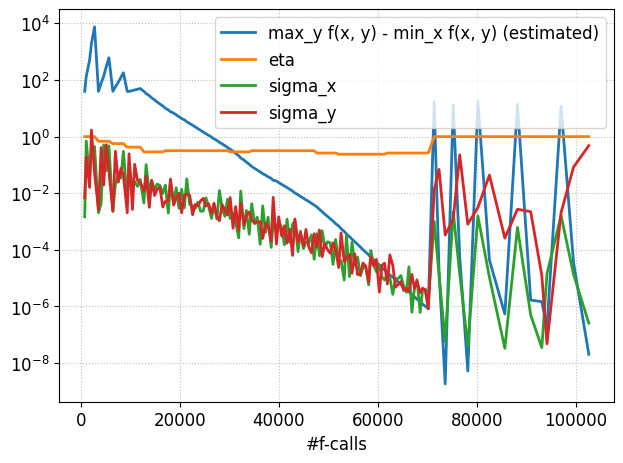

In [22]:
import os

# 簡単のため， x と y の次元数は等しいとする．
N = 10
a = c = 1.0
b = 10.0

def f(x, y):
    return a * np.dot(x, x) + b * np.dot(x, y) - c * np.dot(y, y)

def f_worst(x):
    y = b * x / 2 / c
    return f(x, y)

np.random.seed(100)
m = n = 10
a = 1
b = 4
c = 1
bounded = False
# Initialization Interval
xlbound = -np.ones(m)
xubound = np.ones(m)
ylbound = -np.ones(n)
yubound = np.ones(n)
# Optimization
maxeval = 1e5
logpre = 'advcma_ftest'
logpath = logpre + '.csv'
logpathx = logpre + '_x.csv'
logpathy = logpre + '_y.csv'
logpathworst = logpre + '_worst_y.csv'
os.remove(logpath)
os.remove(logpathx)
os.remove(logpathy)
os.remove(logpathworst)
print("Optimization has started.")
fxy, xbest, yworst, f_arr, x_arr, y_arr = minmax(f, xlbound, xubound, ylbound, yubound, maxeval, bounded, etamin=1e-4, tolgap=1e-6, tolxsigma=1e-8, tolysigma=1e-8, logpath=logpath, logchol=False)
print("Optimization has finished.")
print("best x:", xbest)
print("worst y:", yworst)
print("f(x,y):", fxy)
print(f_arr)
np.savetxt(logpathx, x_arr)
np.savetxt(logpathy, y_arr)
# Evaluation
print("Worst-case search has started.")
fy, y, f_arr, y_arr = worstsearch(f, xbest, ylbound, yubound, bounded, maxeval=100*len(ylbound), tolsigma=1e-8, n_restart=100)
print("Worst-case search has finished.")
print("worst y:", y)
print("f(x,y):", fy)
print(f_arr)
np.savetxt(logpathworst, y_arr)
# Plot
dat = np.loadtxt(logpath)
fig = plt.figure()
plt.semilogy(dat[:, 0], dat[:, 2], label="max_y f(x, y) - min_x f(x, y) (estimated)")
plt.semilogy(dat[:, 0], dat[:, 3], label="eta")
plt.semilogy(dat[:, 0], dat[:, -2], label="sigma_x")
plt.semilogy(dat[:, 0], dat[:, -1], label="sigma_y")
plt.grid()
plt.xlabel("#f-calls")
plt.legend()
plt.tight_layout()
plt.savefig("advcma_ftest.pdf")

ミニマックス最適化によって得られた最適解が xbest，その際の最悪シナリオが yworst，その目的関数値（すなわち推定された最悪性能$f(xbest, yworst)$）がfxyである．
その後，ワーストケース探索を行って得られた最悪シナリオが y，その目的関数値がfy である．
今回の場合，真の最悪性能が既知であるためこれを計算すると， fy と非常に近い値になっていることが確認できる．
真の最悪性能の最小値は 0 であるため，最適解近傍の解が得られていることが確認できる．

In [23]:
xbest

array([ 5.37337112e-05, -5.84030215e-05, -1.27900586e-05, -3.65376065e-05,
       -7.69818137e-05,  6.75632374e-05,  2.44250604e-05, -1.06984617e-04,
        8.36227914e-05, -3.75695046e-05])

In [25]:
yworst

array([-9.15851035e-05,  5.02525653e-05,  2.72482986e-05,  9.11436203e-05,
        2.54611610e-05, -1.12192295e-04, -9.07385274e-05,  1.18534937e-04,
       -1.06733320e-04,  5.65214866e-05])

In [26]:
fxy

-2.1942027980827364e-07

In [28]:
y

array([ 1.07401574e-04, -1.16779529e-04, -2.56047875e-05, -7.30599495e-05,
       -1.53904808e-04,  1.35045394e-04,  4.88420409e-05, -2.13960143e-04,
        1.67279194e-04, -7.51660213e-05])

In [29]:
fy

1.9367162371873382e-07

In [30]:
f_worst(xbest)

1.93671641640345e-07